# 불균형데이터의 예측 성능

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams['font.family']='Malgun Gothic' # 한글폰트

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.pipeline import Pipeline, make_pipeline
import scikitplot as skplt
from joblib import dump, load

# START GUIDE 101
## How to deal with an imbalanced dataset
https://medium.com/analytics-vidhya/how-to-deal-with-an-imbalanced-dataset-47c8ce98c459

# 허위양성 파라독스

### 불균형 데이터가 인지적 오류를 줄 수 있는 경우를 살펴보자. 
- 전체 인구가 1,000명인 도시에 수도물 알러지가 있는 사람을 1%이고
- 알러지 진단 테스트는 99% 정확하다고 가정한다.

In [3]:
cross = np.array([[9801, 99], [0, 100]])
data = pd.DataFrame(cross, index=['정상인', '비정상인'], 
                    columns=['(정상판정)Test negative', '(알러지판정)Test positive'])
data['Total']= data.sum(axis=1)
data.loc['Total'] = data.sum()
data

,(정상판정)Test negative,(알러지판정)Test positive,Total
정상인,9801,99,9900
비정상인,0,100,100
Total,9801,199,10000


### 알러지가 없는데 있다고 진단할 확률은 1%, 알러지가 있다면 항상 100% 알러지 진단을 한다
### 허위양성율과 참양성율이 각각 1%와 100%라는 의미이다.

In [4]:
tn = data.iloc[0,0]; fp=data.iloc[0,1]
fn = data.iloc[1,0]; tp=data.iloc[1,1]
fpr = fp/data.iloc[0,2]; tpr = tp/data.iloc[1,2]
print(f'알러지가 없는데 있다고 진단할 확률(허위양성율, fpr)은 {fpr*100} %')
print(f'알러지가 있는데 없다고 진단할 확률(참음성율, tpr)은 {tpr*100} %')

알러지가 없는데 있다고 진단할 확률(허위양성율, fpr)은 1.0 %
알러지가 있는데 없다고 진단할 확률(참음성율, tpr)은 100.0 %


## <font color='red'> 알러지 진단을 받았다면 실제로 알러지일 확률은 겨우 ‘50.25%’이다. 

In [5]:
print(f'알러지 진단을 받았는데 실제 알러지일 확률(양성 정밀도)은 {tp/(fp+tp)*100} %')

알러지 진단을 받았는데 실제 알러지일 확률(양성 정밀도)은 50.25125628140703 %


<img src='https://www.nbshare.io/static/snapshots/cm_colored_1-min.png'>

## Threshold value에 따른 변화
<img src='https://www.jeremyjordan.me/content/images/2018/11/roc_cutoff-1.gif'>

### 아주 적은 비율의 알러지를 가진 모집단일 경우 진단 테스트(예측 모형) 정확도는 판단 오류를 준다. 
### 모집단의 알러지 비중이 커질수록 진단을 받았다면 실제 알러지일 확률은 증가한다. 
### 불균형데이터가 많은 의료분야 검사의 경우 진단 테스트의 정확도, 재현율, 정확도를 모두 고려하여야 한다.

Text(0.5, 1.0, 'Multivariates pdf')

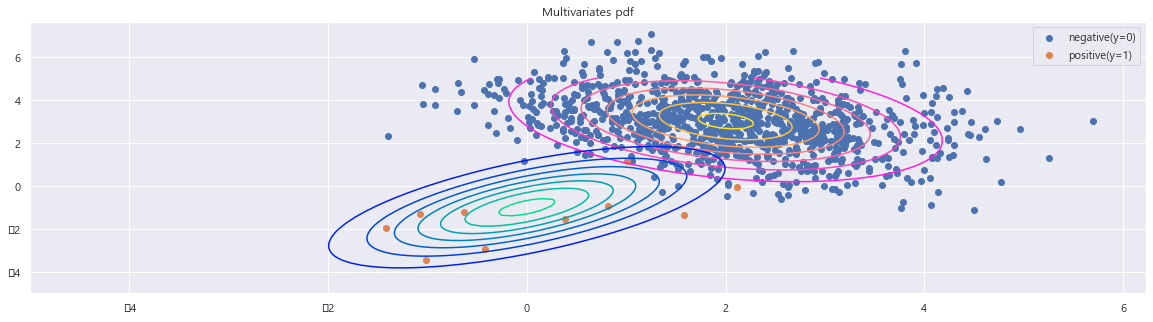

In [6]:
import scipy.stats as stats
np.random.seed(13)

rv0 = stats.multivariate_normal([2, 3], [[1.2, -0.5], [-0.5, 2]]) # negative
rv1 = stats.multivariate_normal([0, -1], [[1, 0.9], [0.9, 2]])   # positive
x0 = rv0.rvs(990); x1 = rv1.rvs(10) # it is a fitting! ()

xx1 = np.linspace(-5, 5, 100); xx2 = np.linspace(-5, 5, 100)
xx1, xx2 = np.meshgrid(xx1, xx2)

fig = plt.figure(figsize=(20,5))
plt.contour(xx1, xx2, rv0.pdf(np.dstack([xx1, xx2])), cmap='spring')
plt.contour(xx1, xx2, rv1.pdf(np.dstack([xx1, xx2])), cmap='winter')
plt.scatter(x0[:, 0], x0[:, 1], label='negative(y=0)')
plt.scatter(x1[:, 0], x1[:, 1], label='positive(y=1)')
plt.legend(); plt.title("Multivariates pdf")

plt.show()

## 데이터 불러오기

### kaggle('../data/creditcard.csv'')로 search
https://www.kaggle.com/mlg-ulb/creditcardfraud

In [7]:
df = pd.read_csv("../data/creditcard.csv")
df.head()
df.shape

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


(284807, 31)

## 데이터 전처리

In [8]:
df['Class'].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df.iloc[:,:-1] = scaler.fit_transform(df.iloc[:,:-1])
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996583,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,...,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.392170,0.330892,-0.063781,0.244964,0
1,-1.996583,0.608496,0.161176,0.109797,0.316523,0.043483,-0.061820,-0.063700,0.071253,-0.232494,...,-0.307377,-0.880077,0.162201,-0.561131,0.320694,0.261069,-0.022256,0.044608,-0.342475,0
2,-1.996562,-0.693500,-0.811578,1.169468,0.268231,-0.364572,1.351454,0.639776,0.207373,-1.378675,...,0.337632,1.063358,1.456320,-1.138092,-0.628537,-0.288447,-0.137137,-0.181021,1.160686,0
3,-1.996562,-0.493325,-0.112169,1.182516,-0.609727,-0.007469,0.936150,0.192071,0.316018,-1.262503,...,-0.147443,0.007267,-0.304777,-1.941027,1.241904,-0.460217,0.155396,0.186189,0.140534,0
4,-1.996541,-0.591330,0.531541,1.021412,0.284655,-0.295015,0.071999,0.479302,-0.226510,0.744326,...,-0.012839,1.100011,-0.220123,0.233250,-0.395202,1.041611,0.543620,0.651816,-0.073403,0


In [10]:
df= df.sample(frac=0.1)

In [11]:
X = df.drop(['Class', 'Amount'], axis=1).iloc[:, 4:7]
y = df['Class']

In [12]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, 
                                                  stratify= y, random_state=11)

In [13]:
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression(random_state=11)
y_predict = lgr.fit(X_train, y_train).predict(X_test)
accuracy_score(y_test, y_predict)

0.9982446901878181

In [14]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5687
           1       0.50      0.30      0.37        10

    accuracy                           1.00      5697
   macro avg       0.75      0.65      0.69      5697
weighted avg       1.00      1.00      1.00      5697



array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

Text(0.5, 1.0, '양성판정확률의 분포')

Text(0.5, 0, '양성판정확률')

0.9989490681905978

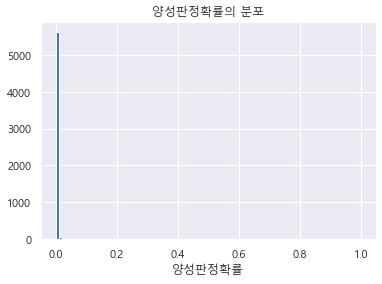

In [15]:
y_scores = lgr.predict_proba(X_test)[:, 1]
pd.DataFrame(y_scores).hist(bins=100)
plt.title('양성판정확률의 분포'); plt.xlabel('양성판정확률')
np.max(y_scores)

In [16]:
y_scores

array([1.04204963e-04, 5.82361114e-04, 7.74112795e-04, ...,
       7.97568589e-06, 1.64450012e-03, 3.76935586e-04])

## 1. 손실함수 조정(Sklearn utils)

In [17]:
model = LogisticRegression(random_state=11, class_weight='balanced')
y_predict = model.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96      5687
           1       0.02      0.80      0.04        10

    accuracy                           0.93      5697
   macro avg       0.51      0.86      0.50      5697
weighted avg       1.00      0.93      0.96      5697



In [18]:
y.value_counts(normalize=True)
negative = y.value_counts(normalize=True)[0]
positive = y.value_counts(normalize=True)[1]

0    0.998315
1    0.001685
Name: Class, dtype: float64

In [19]:
model = LogisticRegression(random_state=11, class_weight={0: positive, 1: negative})
y_predict = model.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96      5687
           1       0.02      0.70      0.03        10

    accuracy                           0.93      5697
   macro avg       0.51      0.82      0.50      5697
weighted avg       1.00      0.93      0.96      5697



array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

Text(0.5, 1.0, '양성판정확률의 분포')

Text(0.5, 0, '양성판정확률')

0.9999995773746334

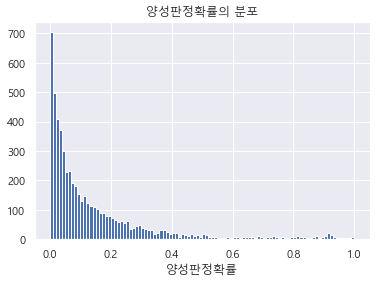

In [20]:
y_scores = model.predict_proba(X_test)[:, 1]
pd.DataFrame(y_scores).hist(bins=100)
plt.title('양성판정확률의 분포'); plt.xlabel('양성판정확률')
np.max(y_scores)

## 1. Sklearn utils
### 손실함수 조정이 가능한 알고리즘

In [21]:
# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier)
# metrics
from sklearn.metrics import roc_curve, precision_recall_curve, auc, precision_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score
from sklearn.metrics import f1_score, recall_score, log_loss, brier_score_loss, matthews_corrcoef
from scipy.stats import ks_2samp

In [22]:
classifiers = {}
classifiers.update({'LGR': LogisticRegression(class_weight='balanced')})
classifiers.update({'SVC': SVC(class_weight='balanced', max_iter= 100, probability=True)})
classifiers.update({'Decisiontree': DecisionTreeClassifier(class_weight='balanced')})
classifiers.update({'Extratree': ExtraTreesClassifier(class_weight='balanced', n_estimators=250)})
classifiers.update({'Random Forest': RandomForestClassifier(class_weight='balanced', n_estimators=100)})

In [23]:
from tqdm import tqdm_notebook
kf = KFold(n_splits=2)
results = {}

for classifier_label, classifier in tqdm_notebook(classifiers.items()):
    steps = [('classifier', classifier)]
    pipeline = Pipeline(steps = steps)
    param_grid = {}
    
    gs = RandomizedSearchCV(pipeline, param_grid, cv = kf,
                          n_iter = 2,
                          scoring = 'f1_macro')  
    y_pred = gs.fit(X_train, y_train).predict(X_test)
    y_proba = gs.predict_proba(X_test)
    y_score = y_proba[:,1]
    
    result = {'Best Parameters': gs.best_params_,
              'AUROC': roc_auc_score(y_test, y_score),
              'Average PR': average_precision_score(y_test, y_score),
              'F1-score': f1_score(y_test, y_pred),
              'Log_loss': log_loss(y_test, y_proba),
              'Brier_score': brier_score_loss(y_test, y_score),
             }
 
    results.update({classifier_label: result})

  0%|          | 0/5 [00:00<?, ?it/s]

In [24]:
pd.DataFrame(results).T.drop(['Best Parameters'], axis=1).sort_values('Log_loss')

,AUROC,Average PR,F1-score,Log_loss,Brier_score
SVC,0.537999,0.00298,0.003504,0.014235,0.001761
Extratree,0.739151,0.312153,0.461538,0.032848,0.001339
Random Forest,0.691999,0.304228,0.461538,0.038093,0.001353
Decisiontree,0.649648,0.1298,0.352941,0.066689,0.001931
LGR,0.951644,0.320835,0.038005,0.228605,0.061753


# 2 SMOTE
- 가우시안 나이브 등과 같은 알고리즘은 Class weight 파라미터가 없음

In [25]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

In [26]:
from collections import Counter
#Showing the diference before and after the transformation used
print("normal data distribution: {}".format(Counter(y)))

normal data distribution: Counter({0: 28433, 1: 48})


In [27]:
X_smote, y_smote = SMOTE().fit_resample(X,y) # SMOTE().fit_sample(X, y)
print("SMOTE data distribution: {}".format(Counter(y_smote)))

SMOTE data distribution: Counter({0: 28433, 1: 28433})


In [28]:
smote_pipeline = make_pipeline(SMOTE(random_state=4),
                               lgr)

In [29]:
smote_model = smote_pipeline.fit(X_train, y_train)
smote_prediction = smote_model.predict(X_test)

In [30]:
from sklearn.metrics import confusion_matrix
print("Confusion Matrix: ")

print(classification_report(y_test, smote_prediction))
print(confusion_matrix(y_test, smote_prediction))

Confusion Matrix: 
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      5687
           1       0.02      0.70      0.04        10

    accuracy                           0.94      5697
   macro avg       0.51      0.82      0.50      5697
weighted avg       1.00      0.94      0.97      5697

[[5336  351]
 [   3    7]]


In [31]:
cross_val_score(smote_pipeline, X_train, y_train, scoring='recall_macro', cv=kf)

array([0.93806384, 0.81672087])

## <font color='red'> 선교차검증 후 데이터 전처리

In [32]:
from imblearn.pipeline import make_pipeline
imba_pipeline = make_pipeline(StandardScaler(), 
                              SMOTE(random_state=42), 
                              RandomForestClassifier(random_state=13))

In [33]:
X = df.drop(['Class', 'Amount'], axis=1).iloc[:, 4:7]
y = df['Class']

In [34]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, 
                                                  stratify= y, random_state=11)

In [35]:
cross_val_score(imba_pipeline, X_train, y_train, scoring='recall_macro', cv=kf)

array([0.7978389 , 0.73074038])

In [36]:
smote_prediction = imba_pipeline.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, smote_prediction))
print(confusion_matrix(y_test, smote_prediction))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5687
           1       0.06      0.30      0.09        10

    accuracy                           0.99      5697
   macro avg       0.53      0.65      0.54      5697
weighted avg       1.00      0.99      0.99      5697

[[5636   51]
 [   7    3]]


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

Text(0.5, 1.0, '양성판정확률의 분포')

Text(0.5, 0, '양성판정확률')

1.0

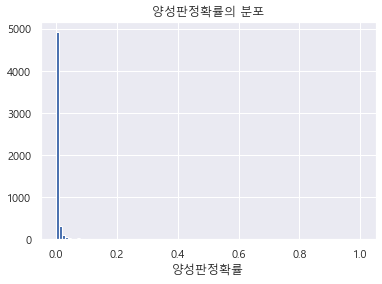

In [37]:
y_scores = imba_pipeline.predict_proba(X_test)[:, 1]
pd.DataFrame(y_scores).hist(bins=100)
plt.title('양성판정확률의 분포'); plt.xlabel('양성판정확률')
np.max(y_scores)

### 소수 범주 자료를 다수 범주 자료의 60%까지 오버샘플링(sampling_strategy = 0.6)


In [38]:
kf = KFold(n_splits=2)
cross_val_score(imba_pipeline, X_train, y_train, scoring='recall_macro', cv=kf)

array([0.7978389 , 0.73074038])

In [39]:
for i in [0.3, 0.4, 0.5, 0.6, 0.7]:
    imba_pipeline = make_pipeline(StandardScaler(),
                                  SMOTE(sampling_strategy = i, random_state=42),
                                  RandomForestClassifier(random_state=13))
    print(f'sampling_strategy = {i}')
    cross_val_score(imba_pipeline, X_train, y_train, scoring='recall_macro', cv=kf)
    print('*'*100)

sampling_strategy = 0.3


array([0.79920225, 0.69762679])

****************************************************************************************************
sampling_strategy = 0.4


array([0.79854257, 0.66416161])

****************************************************************************************************
sampling_strategy = 0.5


array([0.79849859, 0.7973631 ])

****************************************************************************************************
sampling_strategy = 0.6


array([0.79814675, 0.69731915])

****************************************************************************************************
sampling_strategy = 0.7


array([0.79797084, 0.73065249])

****************************************************************************************************


# END